# mini_project_3.ipynb

Group Members:
- Peter Bollhorn
- Tobias Thormod Birk Nielsen

This notebook presents our solution to Mini Project 3, where we work with data from The Movie Database (TMDB) https://www.themoviedb.org/

In the notebook **read_tmdb_data.ipynb** we read JSON data from TMDB's API and store it as CSV files:
- **danish_movies.csv**: Data on all Danish-language movies ever made up to and including 2024-12-31.
- **danish_actors.csv**: Data on all actors that appear in these movies (also foreign actors).

Here is the machine learning we do in the different tasks:
- Task 2: We use linear regression to see if there is a linear relationship between actor age and movie count.
- Task 3: We use classiciation to see if we can predict actor gender from their age and movie count.
- Task 4: We use clustering to see


TMDB works with these genders:
| value  | Gender                  |
|--------|-------------------------|
| 0      | Not set / not specified |
| 1      | Female                  |
| 2      | Male                    |
| 3      | Non-binary              |

And TMDB works with these genres:
| genre_id | Genre           |
|----------|-----------------|
| 28       | Action          |
| 12       | Adventure       |
| 16       | Animation       |
| 35       | Comedy          |
| 80       | Crime           |
| 99       | Documentary     |
| 18       | Drama           |
| 10751    | Family          |
| 14       | Fantasy         |
| 36       | History         |
| 27       | Horror          |
| 10402    | Music           |
| 9648     | Mystery         |
| 10749    | Romance         |
| 878      | Science Fiction |
| 10770    | TV Movie        |
| 53       | Thriller        |
| 10752    | War             |
| 37       | Western         |

In [1]:
import sys
sys.path.append("..")

import pandas as pd
import ast  # Abstract Syntax Trees - safely parse string list to Python list
import seaborn as sns
import matplotlib.pyplot as plt
from reader import generic_reader

## Task 1: Data wrangling and exploration

First we read in danish_movies.csv and have a look at the data. We see that there is a total of 5134 movies.

In [2]:
danish_movies = generic_reader.read_csv_file_to_data_frame("movie_data/danish_movies.csv")
print(danish_movies.info())
danish_movies

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5134 entries, 0 to 5133
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   adult                   5134 non-null   bool   
 1   backdrop_path           1959 non-null   object 
 2   budget                  5134 non-null   int64  
 3   homepage                245 non-null    object 
 4   id                      5134 non-null   int64  
 5   imdb_id                 3689 non-null   object 
 6   origin_country          5134 non-null   object 
 7   original_language       5134 non-null   object 
 8   original_title          5134 non-null   object 
 9   overview                3895 non-null   object 
 10  popularity              5134 non-null   float64
 11  poster_path             4089 non-null   object 
 12  production_countries    5134 non-null   object 
 13  release_date            5134 non-null   object 
 14  revenue                 5134 non-null   

,adult,backdrop_path,budget,homepage,id,imdb_id,origin_country,original_language,original_title,overview,...,video,vote_average,vote_count,genre_ids,production_company_ids,collection_id,cast_person_ids,cast_credit_ids,crew_person_ids,crew_credit_ids
0,False,NaN,0,NaN,195139,tt0290709,['DK'],da,Kørsel med Grønlandske hunde,"Johan Carl Joensen, a Danish colonial manager ...",...,False,5.3,15,[99],[41774],NaN,[2452695],['5dc5d410470ead001391303b'],"[1171313, 1171313]","['52fe4d069251416c91108121', '5dc5d3ef470ead00..."
1,False,NaN,0,NaN,232636,tt0348157,['DK'],da,Svanerne i Sortedamssøen,Swans getting handled as people watch.,...,False,3.0,2,[99],[41774],NaN,[],[],[1171313],['52fe4e07c3a36847f827a04d']
2,False,NaN,0,NaN,195364,tt0346587,['DK'],da,Bech Olsens og Poul Pons' brydekamp,Early wrestling footage.,...,False,4.0,5,[99],[41774],NaN,"[4658231, 4658234]","['661fe77220af77017d3f88a8', '661fe78a6d9fe801...",[1171313],['52fe4d0d9251416c91108ee5']
3,False,NaN,0,NaN,232637,tt1469330,['DK'],da,Badescener fra Skovshoved,Fun at the beach.,...,False,4.5,4,[99],[41774],NaN,[],[],[1171313],['52fe4e07c3a36847f827a057']
4,False,NaN,0,NaN,195305,tt0347357,['DK'],da,De Kongelige skal fotograferes,"Filmed while the Christian IX, King of Denmark...",...,False,4.8,4,[99],[],NaN,[],[],[1171313],['52fe4d0b9251416c91108c3d']
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5129,False,/MSP35R6y0ypmf3zU1kyUw1P4It.jpg,0,NaN,1407803,NaN,['DK'],da,Verdensmænd - Bobos surprise,NaN,...,False,10.0,1,[35],[758],NaN,"[1828049, 234058, 1355004, 88356, 2208065]","['676d44614ca2fbbfca614283', '676d44784ca2fbbf...",[],[]
5130,False,/2iVVzCEnX4QMEeyd3e52juYcsH8.jpg,0,NaN,1410638,NaN,['DK'],da,Gud bevare Danmark,NaN,...,False,0.0,0,[],[],NaN,[],[],[],[]
5131,False,/ej5uQVMJTzq8nZBCbf6pUMNF6jl.jpg,0,NaN,1409581,NaN,['DK'],da,Frank Hvam - Nobody,Frank Hvam has lived in New Zealand with his f...,...,False,6.0,1,[35],[758],NaN,[89973],['67724668d8dc22e6c6927586'],"[89973, 5520795, 563909, 5227452, 4263643, 516...","['68650819af3c4b2566414b34', '686508769febd451..."
5132,False,NaN,0,NaN,1412034,NaN,['DK'],da,"Dan Andersen - Nedsat Hørelse, Nedsat Sædkvali...",NaN,...,False,0.0,0,[35],[],NaN,[149860],['677903662b097b15a274ab1e'],[],[]


Now we read in danish_actors.csv and have a look at the data. We see that a total of 15602 actors appear in these movies (including foreign actors).

In [3]:
danish_actors = generic_reader.read_csv_file_to_data_frame("movie_data/danish_actors.csv")
print(danish_actors.info())
danish_actors

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15602 entries, 0 to 15601
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   actor_id              15602 non-null  int64  
 1   movie_ids             15602 non-null  object 
 2   adult                 15602 non-null  bool   
 3   also_known_as         15602 non-null  object 
 4   biography             1067 non-null   object 
 5   birthday              4257 non-null   object 
 6   deathday              1189 non-null   object 
 7   gender                15602 non-null  int64  
 8   homepage              449 non-null    object 
 9   imdb_id               7569 non-null   object 
 10  known_for_department  15602 non-null  object 
 11  name                  15602 non-null  object 
 12  place_of_birth        3276 non-null   object 
 13  popularity            15602 non-null  float64
 14  profile_path          4702 non-null   object 
dtypes: bool(1), float64

,actor_id,movie_ids,adult,also_known_as,biography,birthday,deathday,gender,homepage,imdb_id,known_for_department,name,place_of_birth,popularity,profile_path
0,42,"{658817, 456325, 29445, 1354636, 752908, 14460...",False,"['Ларс фон Триер', '拉斯·馮·提爾', 'ラース・フォン・トリアー', ...",Lars von Trier (born Lars Trier; 30 April 1956...,1956-04-30,NaN,2,NaN,nm0001885,Directing,Lars von Trier,"Kongens Lyngby, Danmark",0.9635,/a1zVySI0Yqqf3ORegQ1icMfvhAa.jpg
1,53,{15843},False,"['Rolf Peter Ingvar Storm', 'پیتر استورماره', ...","Peter Stormare (August 27, 1953) was born in A...",1953-08-27,NaN,2,NaN,nm0001780,Acting,Peter Stormare,"Arbrå, Gävleborgs län, Sweden",5.0311,/1rtpuUqBV29jDc1huUhtjGDbEwn.jpg
2,169,{8883},False,[],Hanns Zischler (born 18 June 1947) is a German...,1947-06-18,NaN,2,NaN,nm0957193,Acting,Hanns Zischler,"Nuremberg, Bavaria, Germany",0.2330,/5O4Dum1OuKI4RMB24xjACkL22iA.jpg
3,378,{266285},False,"['Джонатан Прайс', '조너선 프라이스', '乔纳森·普雷斯', 'جان...","Jonathan Pryce, CBE (born 1 June 1947) is a We...",1947-06-01,NaN,2,NaN,nm0000596,Acting,Jonathan Pryce,"Carmel, Flintshire, Wales, UK",2.1896,/zwSv5uXzPTtmitFe39UdqnVwmdL.jpg
4,380,{214137},False,"['Robert DeNiro', ' Robert Anthony De Niro Jr....","Robert Anthony De Niro (born August 17, 1943) ...",1943-08-17,NaN,2,NaN,nm0000134,Acting,Robert De Niro,"Greenwich Village, New York City, New York, USA",3.2940,/cT8htcckIuyI1Lqwt1CvD02ynTh.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15597,5706360,{1154066},False,[],NaN,NaN,NaN,0,NaN,NaN,Acting,Thea Esther Saniel Thomsen,NaN,0.0000,NaN
15598,5706385,{1154066},False,[],NaN,NaN,NaN,0,NaN,NaN,Acting,Morten Jay Jakobsen,NaN,0.0000,NaN
15599,5706390,{1154066},False,[],NaN,NaN,NaN,0,NaN,NaN,Acting,Frederik Rasted,NaN,0.0000,NaN
15600,5706467,{1019835},False,[],NaN,NaN,NaN,0,NaN,NaN,Acting,Jytte Vikkelsøe,NaN,0.0000,NaN


For danish_movies data frame, we now drop the columns we are not interested in working with.

And we convert string representations of lists to actual Python lists.

And we convert string representation of release_date to actual Python datetime objects.

In [4]:
columns_to_keep = ['id', 'title', 'release_date', 'runtime', 'vote_average', 'vote_count', 'genre_ids', 'cast_person_ids']
danish_movies = danish_movies[columns_to_keep].copy()
danish_movies['genre_ids'] = danish_movies['genre_ids'].apply(ast.literal_eval)
danish_movies['cast_person_ids'] = danish_movies['cast_person_ids'].apply(ast.literal_eval)
danish_movies['release_date'] = pd.to_datetime(danish_movies['release_date'])
danish_movies

,id,title,release_date,runtime,vote_average,vote_count,genre_ids,cast_person_ids
0,195139,Driving with Greenland Dogs,1897-01-01,1,5.3,15,[99],[2452695]
1,232636,The Swans in Sortedamssøen,1897-12-25,1,3.0,2,[99],[]
2,195364,Bech Olsens og Poul Pons' brydekamp,1899-05-20,1,4.0,5,[99],"[4658231, 4658234]"
3,232637,Bathing Scenes from Skovshoved,1899-09-02,1,4.5,4,[99],[]
4,195305,De Kongelige skal fotograferes,1899-11-25,1,4.8,4,[99],[]
...,...,...,...,...,...,...,...,...
5129,1407803,Verdensmænd - Bobos surprise,2024-12-26,0,10.0,1,[35],"[1828049, 234058, 1355004, 88356, 2208065]"
5130,1410638,Gud bevare Danmark,2024-12-30,0,0.0,0,[],[]
5131,1409581,Frank Hvam - Nobody,2024-12-30,56,6.0,1,[35],[89973]
5132,1412034,"Dan Andersen - Nedsat Hørelse, Nedsat Sædkvali...",2024-12-31,0,0.0,0,[35],[149860]


For danish_actors data frame, we now drop the columns we are not interested in working with.

And we convert string representation of dates to actual Python datetime objects.

In [5]:
columns_to_keep = ['actor_id', 'name', 'gender', 'birthday', 'deathday']
danish_actors = danish_actors[columns_to_keep].copy()
danish_actors['birthday'] = pd.to_datetime(danish_actors['birthday'])
danish_actors['deathday'] = pd.to_datetime(danish_actors['deathday'])
danish_actors

,actor_id,name,gender,birthday,deathday
0,42,Lars von Trier,2,1956-04-30,NaT
1,53,Peter Stormare,2,1953-08-27,NaT
2,169,Hanns Zischler,2,1947-06-18,NaT
3,378,Jonathan Pryce,2,1947-06-01,NaT
4,380,Robert De Niro,2,1943-08-17,NaT
...,...,...,...,...,...
15597,5706360,Thea Esther Saniel Thomsen,0,NaT,NaT
15598,5706385,Morten Jay Jakobsen,0,NaT,NaT
15599,5706390,Frederik Rasted,0,NaT,NaT
15600,5706467,Jytte Vikkelsøe,0,NaT,NaT


In the danish_movies data frame we drop all movies that have runtime shorter than 40 minutes.

We also drop animation films (genre_id=16) and documentaries (genre_id=99).

This is because we only want to work with films that are:
- **Feature-length** (excluding short-films)
- **Live-action** (excluding animation films)
- **Narrative** (exculuding documentaries)

After doing this we have 1623 films left.

In [6]:
danish_movies = danish_movies[danish_movies["runtime"] >= 40]
danish_movies = danish_movies[~danish_movies['genre_ids'].apply(lambda genre_id: 16 in genre_id or 99 in genre_id)]
len(danish_movies)

1623

Now we drop all actors that do not appear in the reduced danish_movies data frame.

In [7]:
# Step 1: Get all unique actor IDs from danish_movies
all_actor_ids = set()
for cast_list in danish_movies['cast_person_ids']:
    all_actor_ids.update(cast_list)
    
# Step 2: Filter danish_actors to only have those who appear in the reduced danish_movies data frame
danish_actors = danish_actors[danish_actors['actor_id'].isin(all_actor_ids)].copy()
danish_actors

,actor_id,name,gender,birthday,deathday
0,42,Lars von Trier,2,1956-04-30,NaT
1,53,Peter Stormare,2,1953-08-27,NaT
2,169,Hanns Zischler,2,1947-06-18,NaT
3,378,Jonathan Pryce,2,1947-06-01,NaT
5,517,Pierce Brosnan,2,1953-05-16,NaT
...,...,...,...,...,...
15591,5701974,Karina Chang,0,NaT,NaT
15592,5706042,Lars Eldrup Jørgensen,0,NaT,NaT
15593,5706048,Staffan Rejle,0,NaT,NaT
15600,5706467,Jytte Vikkelsøe,0,NaT,NaT


Now we calculate movie_count for the actors

In [8]:
# Step 1: explode cast_person_ids so each row has one actor per movie
exploded = danish_movies.explode("cast_person_ids")

# Step 2: count movies per actor
actor_movie_counts = (
    exploded.groupby("cast_person_ids")["id"]
    .nunique()  # use nunique in case of duplicates
    .reset_index()
    .rename(columns={"cast_person_ids": "actor_id", "id": "movie_count"})
)
actor_movie_counts

# Step 3: merge movie_count back into danish_actors
danish_actors = danish_actors.merge(actor_movie_counts, on="actor_id")
danish_actors

,actor_id,name,gender,birthday,deathday,movie_count
0,42,Lars von Trier,2,1956-04-30,NaT,9
1,53,Peter Stormare,2,1953-08-27,NaT,1
2,169,Hanns Zischler,2,1947-06-18,NaT,1
3,378,Jonathan Pryce,2,1947-06-01,NaT,1
4,517,Pierce Brosnan,2,1953-05-16,NaT,1
...,...,...,...,...,...,...
10646,5701974,Karina Chang,0,NaT,NaT,1
10647,5706042,Lars Eldrup Jørgensen,0,NaT,NaT,1
10648,5706048,Staffan Rejle,0,NaT,NaT,1
10649,5706467,Jytte Vikkelsøe,0,NaT,NaT,1


Now we drop actors whose 'birthday' is missing

In [9]:
danish_actors = danish_actors.dropna(subset=["birthday"]).copy()
danish_actors

,actor_id,name,gender,birthday,deathday,movie_count
0,42,Lars von Trier,2,1956-04-30,NaT,9
1,53,Peter Stormare,2,1953-08-27,NaT,1
2,169,Hanns Zischler,2,1947-06-18,NaT,1
3,378,Jonathan Pryce,2,1947-06-01,NaT,1
4,517,Pierce Brosnan,2,1953-05-16,NaT,1
...,...,...,...,...,...,...
10487,5072279,Jakob Engel-Schmidt,2,1983-10-24,NaT,1
10500,5122551,Bertram Lyng Engelsted Jarkilde,2,2008-10-29,NaT,1
10522,5208961,Daniel 'Danny Kool' Sørensen,2,1986-01-09,NaT,1
10553,5244450,Gert Henning-Jensen,2,1965-07-23,NaT,1


We now calculate the age of the actors:
- For living actors: Their age as of 2024-12-31
- For deceased actors: Their age at the time of passing

And hereafter we look at actors when sorted by age.

In [10]:
def calculate_age_from_row(row):
    birthday = row['birthday']
    deathday = row['deathday']
    
    if pd.isna(deathday):
        end_date = pd.to_datetime('2024-12-31')
    else:
        end_date = deathday
    
    age = end_date.year - birthday.year - ((end_date.month, end_date.day) < (birthday.month, birthday.day))
    return age


danish_actors['age'] = danish_actors.apply(calculate_age_from_row, axis=1)
danish_actors.sort_values(by="age", ascending=False)

,actor_id,name,gender,birthday,deathday,movie_count,age
2994,1268234,Maggi Zinn,1,1873-11-16,NaT,1,151
3072,1272622,Moritz Bielawski,2,1885-10-25,NaT,4,139
3107,1273061,Gyda Aller,2,1887-03-12,NaT,3,137
2302,1119020,Marie Ejlersen,1,1892-08-01,NaT,1,132
2161,1086986,Frantz Stybe,2,1894-10-14,NaT,1,130
...,...,...,...,...,...,...,...
9578,3120899,Kerstin Jannerup Gjesing,1,2011-03-31,NaT,1,13
9563,3103149,Marius Damslev,2,2012-11-16,NaT,1,12
9239,2861953,August Christian Høyer-Kruse-Vinkel,2,2012-05-01,NaT,1,12
9965,3755070,Selma Kjær Kuscu,1,2013-02-25,NaT,2,11


We now drop actors who are older than 100 years old, because their 'deathday' is probably missing on TMDB.

And we also drop actors who are 0 or younger, because their data is an error in TMDB's database.

In [11]:
danish_actors = danish_actors[danish_actors['age'] <= 100]
danish_actors = danish_actors[danish_actors['age'] > 0]
danish_actors.sort_values(by="age", ascending=False)

,actor_id,name,gender,birthday,deathday,movie_count,age
1102,153196,Geoffrey Chater,2,1921-03-23,2021-10-16,1,100
1789,928902,Svend Asmussen,2,1916-02-28,2017-02-07,3,100
1673,579178,Susanne Friis,1,1888-01-07,1988-09-07,1,100
3036,1268910,Alma Hinding,1,1882-02-11,1981-12-24,9,99
2142,1079282,Adelaide João,1,1921-07-27,2021-02-03,1,99
...,...,...,...,...,...,...,...
10101,4038903,Silja Ellemann Kiehne,1,2011-09-08,NaT,2,13
9578,3120899,Kerstin Jannerup Gjesing,1,2011-03-31,NaT,1,13
9239,2861953,August Christian Høyer-Kruse-Vinkel,2,2012-05-01,NaT,1,12
9563,3103149,Marius Damslev,2,2012-11-16,NaT,1,12


In [12]:
# Save to CSV
# danish_movies.to_csv("../movie_data/danish_movies_cleaned.csv", index=False)
# danish_actors.to_csv("../movie_data/danish_actors_cleaned.csv", index=False)

In [13]:
danish_actors.shape

(3528, 7)

In [14]:
danish_movies.shape

(1623, 8)

## Task 2: Supervised machine learning: linear regression

<Axes: xlabel='age', ylabel='movie_count'>

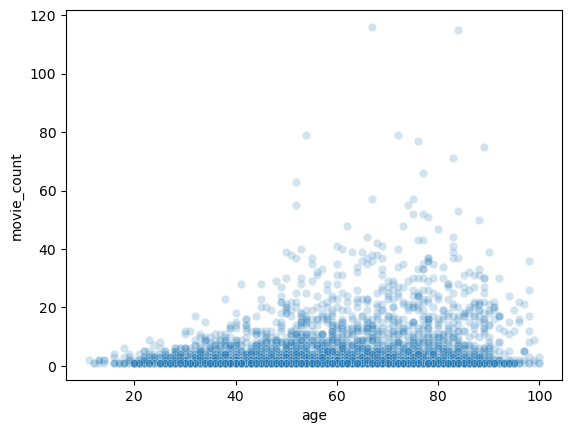

In [15]:
sns.scatterplot(data=danish_actors, x='age', y='movie_count', alpha=0.2)

## Task 3:  Supervised machine learning: classification

## Task 4: Unsupervised machine learning: clustering